***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.3)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training without $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_2_8')

FOLDER CREATED =  ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_8


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 24
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)
    
    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
780/781 [============================>.] - ETA: 0s - loss: 0.3301 - prediction_coarse_accuracy: 0.8357 - prediction_medium_accuracy: 0.3997 - prediction_fine_accuracy: 0.2293
  • Coarse Accuracy = 83.57% | Val_Accuracy = 89.39% | LossWeight = 0.16 
  • Medium Accuracy = 39.97% | Val_Accuracy = 52.48% | LossWeight = 0.43 
  • Fine   Accuracy = 22.94% | Val_Accuracy = 38.01% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.38010, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 50s 55ms/step - loss: 0.3301 - prediction_coarse_accuracy: 0.8357 - prediction_medium_accuracy: 0.3997 - prediction_fine_accuracy: 0.2294 - val_loss: 0.2363 - val_prediction_coarse_accuracy: 0.8939 - val_prediction_medium_accuracy: 0.5248 - val_prediction_fine_accuracy: 0.3801 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.2042 - prediction_coarse_accuracy: 0.8872 -

781/781 [==============================] - 40s 52ms/step - loss: 0.1112 - prediction_coarse_accuracy: 0.9514 - prediction_medium_accuracy: 0.8347 - prediction_fine_accuracy: 0.7657 - val_loss: 0.0775 - val_prediction_coarse_accuracy: 0.9643 - val_prediction_medium_accuracy: 0.8497 - val_prediction_fine_accuracy: 0.7840 - lr: 0.0010
Epoch 10/100
780/781 [============================>.] - ETA: 0s - loss: 0.1089 - prediction_coarse_accuracy: 0.9526 - prediction_medium_accuracy: 0.8376 - prediction_fine_accuracy: 0.7736
  • Coarse Accuracy = 95.26% | Val_Accuracy = 97.10% | LossWeight = 0.17 
  • Medium Accuracy = 83.77% | Val_Accuracy = 85.03% | LossWeight = 0.41 
  • Fine   Accuracy = 77.36% | Val_Accuracy = 78.93% | LossWeight = 0.43 

Epoch 10: val_prediction_fine_accuracy improved from 0.78400 to 0.78930, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 40s 51ms/step - loss: 0.1089 - prediction_coarse_accuracy: 0.9526 - 

Epoch 19/100
780/781 [============================>.] - ETA: 0s - loss: 0.0776 - prediction_coarse_accuracy: 0.9715 - prediction_medium_accuracy: 0.9134 - prediction_fine_accuracy: 0.8751
  • Coarse Accuracy = 97.15% | Val_Accuracy = 97.78% | LossWeight = 0.18 
  • Medium Accuracy = 91.34% | Val_Accuracy = 88.84% | LossWeight = 0.39 
  • Fine   Accuracy = 87.50% | Val_Accuracy = 84.34% | LossWeight = 0.42 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.84550
781/781 [==============================] - 40s 51ms/step - loss: 0.0776 - prediction_coarse_accuracy: 0.9715 - prediction_medium_accuracy: 0.9134 - prediction_fine_accuracy: 0.8750 - val_loss: 0.0558 - val_prediction_coarse_accuracy: 0.9778 - val_prediction_medium_accuracy: 0.8884 - val_prediction_fine_accuracy: 0.8434 - lr: 6.3025e-04
Epoch 20/100
780/781 [============================>.] - ETA: 0s - loss: 0.0747 - prediction_coarse_accuracy: 0.9741 - prediction_medium_accuracy: 0.9215 - prediction_fine_accuracy: 0.

780/781 [============================>.] - ETA: 0s - loss: 0.0662 - prediction_coarse_accuracy: 0.9787 - prediction_medium_accuracy: 0.9411 - prediction_fine_accuracy: 0.9164
  • Coarse Accuracy = 97.87% | Val_Accuracy = 98.03% | LossWeight = 0.20 
  • Medium Accuracy = 94.11% | Val_Accuracy = 90.40% | LossWeight = 0.39 
  • Fine   Accuracy = 91.64% | Val_Accuracy = 86.79% | LossWeight = 0.41 

Epoch 28: val_prediction_fine_accuracy improved from 0.86720 to 0.86790, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 40s 52ms/step - loss: 0.0662 - prediction_coarse_accuracy: 0.9787 - prediction_medium_accuracy: 0.9411 - prediction_fine_accuracy: 0.9164 - val_loss: 0.0486 - val_prediction_coarse_accuracy: 0.9803 - val_prediction_medium_accuracy: 0.9040 - val_prediction_fine_accuracy: 0.8679 - lr: 3.9721e-04
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.0659 - prediction_coarse_accuracy: 0.9790 - pr

781/781 [==============================] - 40s 51ms/step - loss: 0.0618 - prediction_coarse_accuracy: 0.9807 - prediction_medium_accuracy: 0.9510 - prediction_fine_accuracy: 0.9328 - val_loss: 0.0486 - val_prediction_coarse_accuracy: 0.9815 - val_prediction_medium_accuracy: 0.9080 - val_prediction_fine_accuracy: 0.8702 - lr: 2.5034e-04
Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.0613 - prediction_coarse_accuracy: 0.9811 - prediction_medium_accuracy: 0.9512 - prediction_fine_accuracy: 0.9354
  • Coarse Accuracy = 98.11% | Val_Accuracy = 98.20% | LossWeight = 0.22 
  • Medium Accuracy = 95.12% | Val_Accuracy = 90.85% | LossWeight = 0.39 
  • Fine   Accuracy = 93.54% | Val_Accuracy = 87.23% | LossWeight = 0.39 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.87350
781/781 [==============================] - 40s 51ms/step - loss: 0.0613 - prediction_coarse_accuracy: 0.9811 - prediction_medium_accuracy: 0.9512 - prediction_fine_accuracy: 0.9354 - 

Epoch 47/100
780/781 [============================>.] - ETA: 0s - loss: 0.0600 - prediction_coarse_accuracy: 0.9814 - prediction_medium_accuracy: 0.9560 - prediction_fine_accuracy: 0.9420
  • Coarse Accuracy = 98.14% | Val_Accuracy = 98.31% | LossWeight = 0.23 
  • Medium Accuracy = 95.60% | Val_Accuracy = 91.55% | LossWeight = 0.39 
  • Fine   Accuracy = 94.20% | Val_Accuracy = 87.89% | LossWeight = 0.38 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.88040
781/781 [==============================] - 40s 51ms/step - loss: 0.0600 - prediction_coarse_accuracy: 0.9814 - prediction_medium_accuracy: 0.9560 - prediction_fine_accuracy: 0.9420 - val_loss: 0.0455 - val_prediction_coarse_accuracy: 0.9831 - val_prediction_medium_accuracy: 0.9155 - val_prediction_fine_accuracy: 0.8789 - lr: 1.4989e-04
Epoch 48/100
780/781 [============================>.] - ETA: 0s - loss: 0.0597 - prediction_coarse_accuracy: 0.9817 - prediction_medium_accuracy: 0.9565 - prediction_fine_accuracy: 0.

781/781 [==============================] - 40s 51ms/step - loss: 0.0587 - prediction_coarse_accuracy: 0.9820 - prediction_medium_accuracy: 0.9572 - prediction_fine_accuracy: 0.9456 - val_loss: 0.0444 - val_prediction_coarse_accuracy: 0.9832 - val_prediction_medium_accuracy: 0.9151 - val_prediction_fine_accuracy: 0.8785 - lr: 9.4468e-05
Epoch 57/100
780/781 [============================>.] - ETA: 0s - loss: 0.0582 - prediction_coarse_accuracy: 0.9825 - prediction_medium_accuracy: 0.9593 - prediction_fine_accuracy: 0.9490
  • Coarse Accuracy = 98.25% | Val_Accuracy = 98.42% | LossWeight = 0.24 
  • Medium Accuracy = 95.93% | Val_Accuracy = 91.66% | LossWeight = 0.39 
  • Fine   Accuracy = 94.91% | Val_Accuracy = 87.84% | LossWeight = 0.37 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.88060
781/781 [==============================] - 41s 52ms/step - loss: 0.0582 - prediction_coarse_accuracy: 0.9825 - prediction_medium_accuracy: 0.9593 - prediction_fine_accuracy: 0.9491 - 

Epoch 66/100
781/781 [==============================] - ETA: 0s - loss: 0.0575 - prediction_coarse_accuracy: 0.9828 - prediction_medium_accuracy: 0.9598 - prediction_fine_accuracy: 0.9499
  • Coarse Accuracy = 98.28% | Val_Accuracy = 98.37% | LossWeight = 0.24 
  • Medium Accuracy = 95.98% | Val_Accuracy = 91.96% | LossWeight = 0.39 
  • Fine   Accuracy = 94.99% | Val_Accuracy = 88.36% | LossWeight = 0.37 

Epoch 66: val_prediction_fine_accuracy improved from 0.88350 to 0.88360, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 40s 52ms/step - loss: 0.0575 - prediction_coarse_accuracy: 0.9828 - prediction_medium_accuracy: 0.9598 - prediction_fine_accuracy: 0.9499 - val_loss: 0.0430 - val_prediction_coarse_accuracy: 0.9837 - val_prediction_medium_accuracy: 0.9196 - val_prediction_fine_accuracy: 0.8836 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0581 - prediction_coarse_accuracy

780/781 [============================>.] - ETA: 0s - loss: 0.0574 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9603 - prediction_fine_accuracy: 0.9515
  • Coarse Accuracy = 98.37% | Val_Accuracy = 98.42% | LossWeight = 0.23 
  • Medium Accuracy = 96.02% | Val_Accuracy = 91.88% | LossWeight = 0.40 
  • Fine   Accuracy = 95.14% | Val_Accuracy = 88.34% | LossWeight = 0.37 

Epoch 75: val_prediction_fine_accuracy did not improve from 0.88530
781/781 [==============================] - 40s 51ms/step - loss: 0.0574 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9602 - prediction_fine_accuracy: 0.9514 - val_loss: 0.0431 - val_prediction_coarse_accuracy: 0.9842 - val_prediction_medium_accuracy: 0.9188 - val_prediction_fine_accuracy: 0.8834 - lr: 3.5648e-05
Epoch 76/100
780/781 [============================>.] - ETA: 0s - loss: 0.0571 - prediction_coarse_accuracy: 0.9832 - prediction_medium_accuracy: 0.9608 - prediction_fine_accuracy: 0.9522
  • Coar

781/781 [==============================] - 40s 51ms/step - loss: 0.0572 - prediction_coarse_accuracy: 0.9834 - prediction_medium_accuracy: 0.9608 - prediction_fine_accuracy: 0.9513 - val_loss: 0.0424 - val_prediction_coarse_accuracy: 0.9845 - val_prediction_medium_accuracy: 0.9213 - val_prediction_fine_accuracy: 0.8838 - lr: 2.2467e-05
Epoch 85/100
781/781 [==============================] - ETA: 0s - loss: 0.0570 - prediction_coarse_accuracy: 0.9825 - prediction_medium_accuracy: 0.9599 - prediction_fine_accuracy: 0.9511
  • Coarse Accuracy = 98.25% | Val_Accuracy = 98.33% | LossWeight = 0.24 
  • Medium Accuracy = 95.99% | Val_Accuracy = 92.10% | LossWeight = 0.39 
  • Fine   Accuracy = 95.11% | Val_Accuracy = 88.58% | LossWeight = 0.36 

Epoch 85: val_prediction_fine_accuracy improved from 0.88530 to 0.88580, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 40s 51ms/step - loss: 0.0570 - prediction_coarse_accuracy: 0.982

Epoch 94/100
781/781 [==============================] - ETA: 0s - loss: 0.0566 - prediction_coarse_accuracy: 0.9841 - prediction_medium_accuracy: 0.9620 - prediction_fine_accuracy: 0.9533
  • Coarse Accuracy = 98.41% | Val_Accuracy = 98.38% | LossWeight = 0.24 
  • Medium Accuracy = 96.20% | Val_Accuracy = 92.20% | LossWeight = 0.40 
  • Fine   Accuracy = 95.33% | Val_Accuracy = 88.65% | LossWeight = 0.37 

Epoch 94: val_prediction_fine_accuracy did not improve from 0.88670
781/781 [==============================] - 40s 51ms/step - loss: 0.0566 - prediction_coarse_accuracy: 0.9841 - prediction_medium_accuracy: 0.9620 - prediction_fine_accuracy: 0.9533 - val_loss: 0.0421 - val_prediction_coarse_accuracy: 0.9838 - val_prediction_medium_accuracy: 0.9220 - val_prediction_fine_accuracy: 0.8865 - lr: 1.3452e-05
Epoch 95/100
781/781 [==============================] - ETA: 0s - loss: 0.0572 - prediction_coarse_accuracy: 0.9832 - prediction_medium_accuracy: 0.9610 - prediction_fine_accuracy: 0.

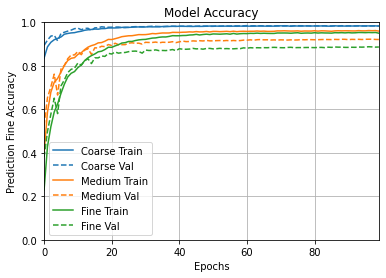

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

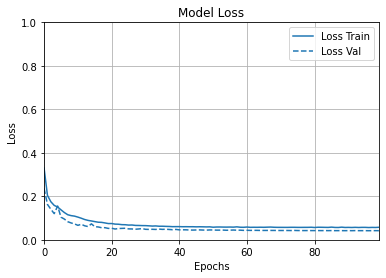

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 6s 15ms/step - loss: 0.0577 - prediction_coarse_loss: 0.0135 - prediction_medium_loss: 0.0585 - prediction_fine_loss: 0.0853 - prediction_coarse_accuracy: 0.9840 - prediction_medium_accuracy: 0.9211 - prediction_fine_accuracy: 0.8867
1. loss ==> 0.057659100741147995
2. prediction_coarse_loss ==> 0.013529910705983639
3. prediction_medium_loss ==> 0.05847582966089249
4. prediction_fine_loss ==> 0.08533169329166412
5. prediction_coarse_accuracy ==> 0.984000027179718
6. prediction_medium_accuracy ==> 0.9211000204086304
7. prediction_fine_accuracy ==> 0.8866999745368958
313/313 [==============================] - 3s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

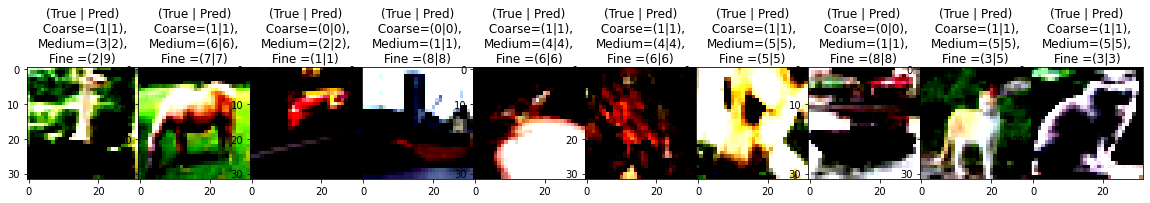

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3928   72]
 [  88 5912]]

  • MEDIUM LEVEL 
[[ 910   22   33   16    3   13    3]
 [  32  927   24    7    4    2    4]
 [  11   10 1968    3    1    5    2]
 [  26    1    8  847   29   44   45]
 [   6    3    2   19  934   25   11]
 [  10    6   18   47   51 1795   73]
 [  10    1    5   47   30   77 1830]]

  • FINE LEVEL 
[[916  10  16   9   1   2   3   1  22  20]
 [  6 954   1   2   0   0   0   0   4  33]
 [ 26   1 855  17  28  22  30  15   1   5]
 [  8   2  34 763  28  93  44  13   5  10]
 [  6   0  37  26 871  14  27  17   1   1]
 [  4   3  22 131  20 795   9  13   1   2]
 [  6   1  18  24   6   1 938   2   2   2]
 [  4   0  15  15  23  23   4 912   0   4]
 [ 32  14   7   1   2   1   3   2 928  10]
 [  6  42   2   4   1   0   1   1   8 935]]

  • Classification Report 


  • COARSE LEVEL 


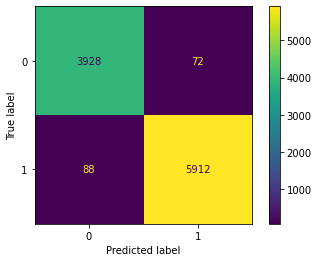

              precision    recall  f1-score   support

           0    0.97809   0.98200   0.98004      4000
           1    0.98797   0.98533   0.98665      6000

    accuracy                        0.98400     10000
   macro avg    0.98303   0.98367   0.98334     10000
weighted avg    0.98402   0.98400   0.98401     10000


  • MEDIUM LEVEL 


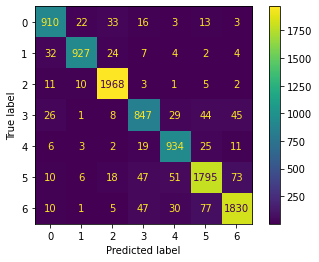

              precision    recall  f1-score   support

           0    0.90547   0.91000   0.90773      1000
           1    0.95567   0.92700   0.94112      1000
           2    0.95627   0.98400   0.96994      2000
           3    0.85903   0.84700   0.85297      1000
           4    0.88783   0.93400   0.91033      1000
           5    0.91535   0.89750   0.90634      2000
           6    0.92988   0.91500   0.92238      2000

    accuracy                        0.92110     10000
   macro avg    0.91564   0.91636   0.91583     10000
weighted avg    0.92110   0.92110   0.92095     10000


  • FINE LEVEL 


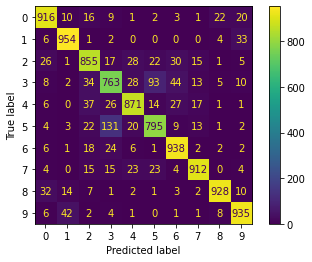

              precision    recall  f1-score   support

           0    0.90335   0.91600   0.90963      1000
           1    0.92892   0.95400   0.94129      1000
           2    0.84906   0.85500   0.85202      1000
           3    0.76915   0.76300   0.76606      1000
           4    0.88878   0.87100   0.87980      1000
           5    0.83596   0.79500   0.81497      1000
           6    0.88574   0.93800   0.91112      1000
           7    0.93443   0.91200   0.92308      1000
           8    0.95473   0.92800   0.94118      1000
           9    0.91487   0.93500   0.92483      1000

    accuracy                        0.88670     10000
   macro avg    0.88650   0.88670   0.88640     10000
weighted avg    0.88650   0.88670   0.88640     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9302716666666667 
Hierarchical Recall = 0.9326 
Hierarchical F1-Score = 0.9312452380952382 
Consistency =  0.9884 
Exact Match =  0.8817
